<a href="https://colab.research.google.com/github/migel-cepele/TestCV/blob/main/TestSolutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Load and visualize the 'coins' image from the skimage built-in datasets. Report the size of the image and range of the pixel grayscale levels.

The size of image is: 303 rows and 384 columns
Range of Pixel Grayscale Levels: [1, 252]


dtype('uint8')

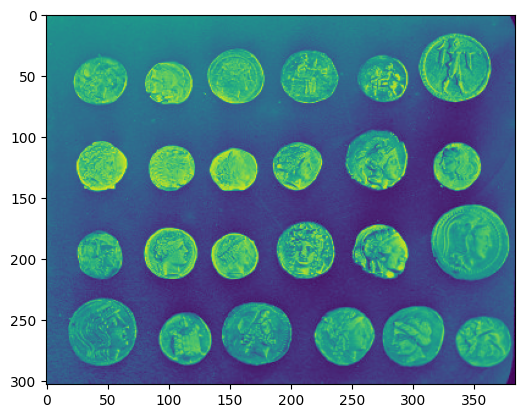

In [9]:
import skimage as sk
import matplotlib.pyplot as plt

coins = sk.data.coins() #get the coins image
plt.imshow(coins) #plot that image with plt

print(f'The size of image is: {coins.shape[0]} rows and {coins.shape[1]} columns')

# Calculate min and max pixel values

min_pixel_value = coins.min()
max_pixel_value = coins.max()

print(f"Range of Pixel Grayscale Levels: [{min_pixel_value}, {max_pixel_value}]")



2. Represent the histogram of the image. Explain the peaks of the histogram in terms of regions of the image.

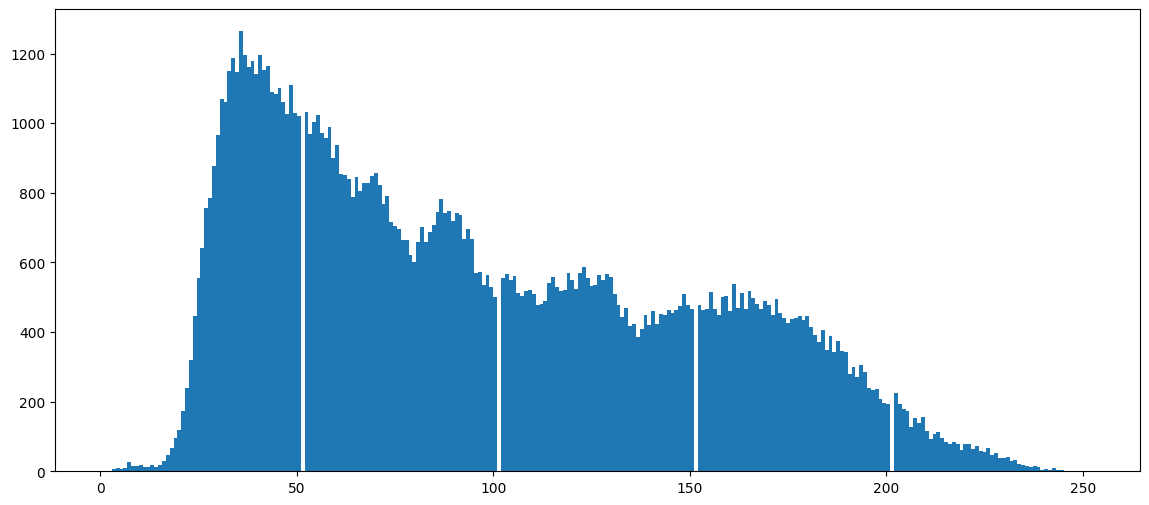

In [10]:
# reshape the uint8 image as 1d array:
v = coins.reshape(coins.shape[0]*coins.shape[1],1)

fig = plt.figure(figsize=(14, 6))
plt.hist(v, bins=256,density=False)
plt.show()

# we see that there are more pixels with low grayscale value than those with high grayscale value
# this is because the image background is darker than the coins, but also coins are not that bright,
# so we dont have many pixels with high grayscale levels

3. Applied noise to the image and use the correct function to erase the noise.

(np.float64(-0.5), np.float64(383.5), np.float64(302.5), np.float64(-0.5))

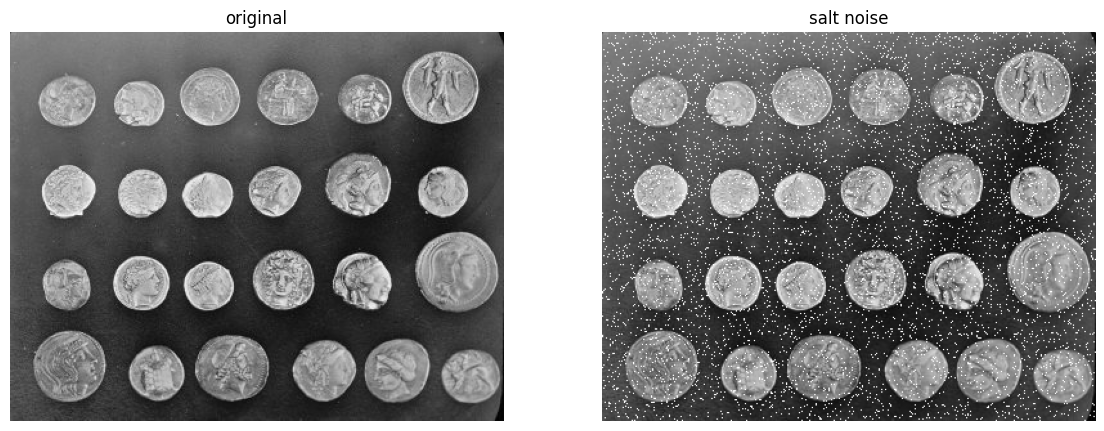

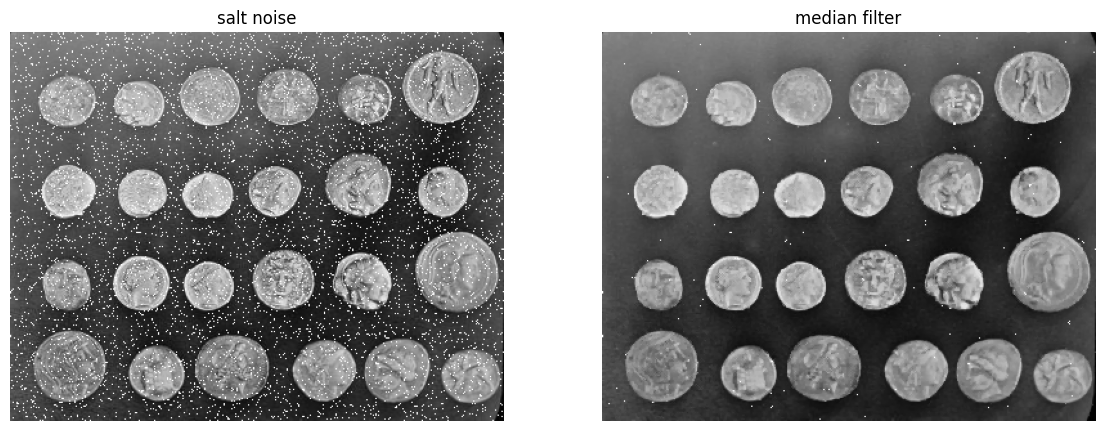

In [13]:
from skimage.util import random_noise
import numpy as np

noisy_image = random_noise(coins, mode='salt') # we create some noise of type salt

from skimage.morphology import disk
from skimage.filters import median
from skimage import img_as_ubyte

#then we use the median filter to clean the image
#this is done by taking the median of 1 pixel neighbours to that pixel, and
#replacing the value of that pixel with the median
img = img_as_ubyte(noisy_image)
sel1 = disk(1) # structuring element disk radius 1 pixels
img_med1x1 = median(img, sel1)

#compare original image with salt image
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 6), sharex=True,
                                   sharey=True)
ax1.imshow(coins, cmap=plt.cm.gray)
ax1.set_title('original')
ax1.axis('off')
ax2.imshow(noisy_image, cmap=plt.cm.gray)
ax2.set_title('salt noise')
ax2.axis('off')

#compare salt image with filtered image
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 6), sharex=True,
                                   sharey=True)
ax1.imshow(noisy_image, cmap=plt.cm.gray)
ax1.set_title('salt noise')
ax1.axis('off')
ax2.imshow(img_med1x1, cmap=plt.cm.gray)
ax2.set_title('median filter')
ax2.axis('off')



4. Segment the image using a k-means clustering algorithm with k=2 and represent the result

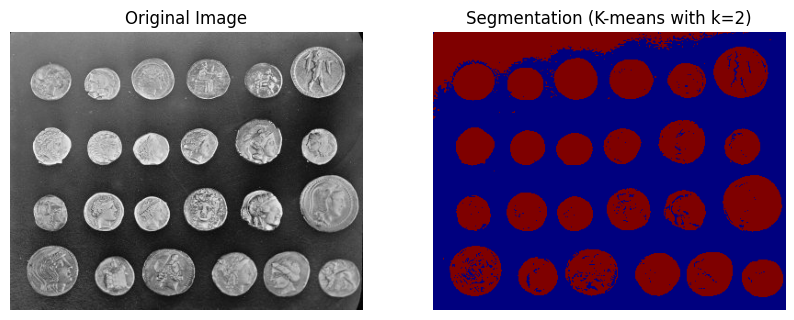

In [19]:
from sklearn.cluster import KMeans
import matplotlib.gridspec as gridspec

# Fit a Kmeans clustering model with two clusters using training image:
n_clus = 2
v_I = np.reshape(coins,(coins.shape[0]*coins.shape[1],1)) # reshape image as NPIX x NCHANNELS array,
#it is only one channel in grayscale images

#create the model
kmeans = KMeans(n_clusters=n_clus, random_state=0).fit(v_I)

#then predict the model using the array of pixels
v_kmeans = kmeans.predict(v_I)

I_kmeans = np.reshape(v_kmeans,(coins.shape[0],coins.shape[1])) # reshape back to original image size

#then we plot the results to see the differences
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(1, 2)

ax1 = fig.add_subplot(gs[0,0])
ax1.imshow(coins, cmap=plt.cm.gray)
ax1.set_title('Original Image')
ax1.set_axis_off()

ax2 = fig.add_subplot(gs[0,1])
ax2.imshow(I_kmeans, cmap=plt.cm.jet)
ax2.set_title('Segmentation (K-means with k={})'.format(n_clus))
ax2.set_axis_off()

plt.show()

#we see that the segmentation using kmeans has correctly separated brighter
#objects like coins and some part of the image, with the darker background

5. Label the objects found in the image. Generate a figure with the original image and the labeled image. How many coins are there in the image?

Number of coins detected: 26


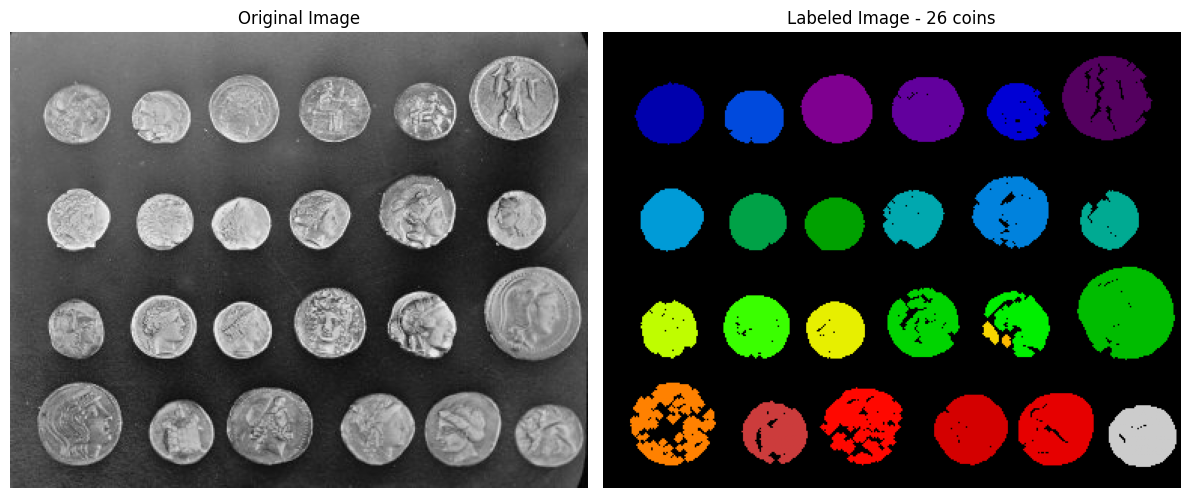

In [89]:
import matplotlib.pyplot as plt
from skimage import data
from skimage.filters import threshold_otsu
from skimage.morphology import binary_opening, disk
from skimage.measure import label, regionprops
from skimage.segmentation import clear_border


# Step 1: Threshold with Otsu, to separate the coins and background
thresh = threshold_otsu(coins)
binary = coins > thresh  # coins are brighter, so we select those above threshhold value

# Step 2: Remove small noise using morphological opening
# binary opening is a series of erosions and dilations
selem = disk(2)
binary_cleaned = binary_opening(binary, selem)

# Optional: Clear objects touching the border
binary_cleaned = clear_border(binary_cleaned)

# Step 3: Label connected components
label_image, num_coins = label(binary_cleaned, return_num=True)

print(f"Number of coins detected: {num_coins}")

# Step 4: Plot original and labeled image side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ax = axes.ravel()

ax[0].imshow(coins, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(label_image, cmap='nipy_spectral')
ax[1].set_title(f'Labeled Image - {num_coins} coins')
ax[1].axis('off')

plt.tight_layout()
plt.show()

#we get 2 more coins than the real number of coins the image has, but we get a clear picture of coin segmentation

6. Extract the area, major axis length and orientation of each coin. Report the average values of the extracted features. Represent a scatterplot of the area vs major axis length.

Mean area 1386.923076923077, mean axis 43.89988665281816 and mean orientation -0.08349944005094165


<Axes: xlabel='area', ylabel='axis_major_length'>

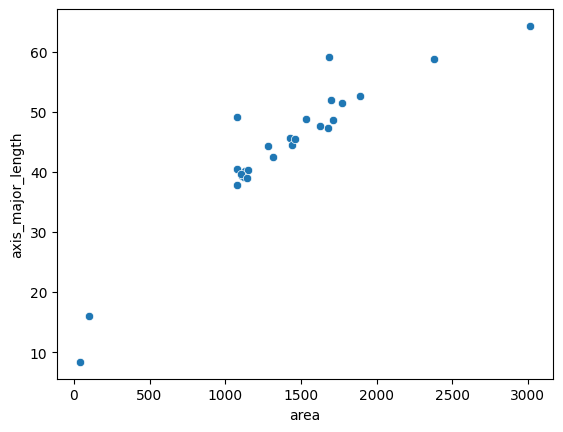

In [90]:
import pandas as pd
from skimage import measure

# first we extract the given features
props = measure.regionprops_table(label_image,properties=['label','area','axis_major_length', 'orientation'])

df_features = pd.DataFrame(props)
df_features.head()

# then we find the means of all of those features
mean_area = df_features['area'].mean()
mean_axis_major_length = df_features['axis_major_length'].mean()
mean_orientation = df_features['orientation'].mean()

print(f'Mean area {mean_area}, mean axis {mean_axis_major_length} and mean orientation {mean_orientation}')

#scatter plot features
import seaborn as sns

sns.scatterplot(x='area',y='axis_major_length',data=df_features)

7. Using the labeled regions from the 'coins' image, how can I filter the regions to find those with an area greater than 1750 pixels, count how many such coins there are?

In [91]:
df_large_coins = df_features.loc[df_features['area']> 1750]
N_large = df_large_coins.shape[0]
print('there are {} coins with an area larger or equal the 1750 pixels'.format(N_large))

there are 4 coins with an area larger or equal the 1750 pixels


8. Generate a 3-panel figure with the original image, the image with the little coins < 1750 coins (red color) and an image with the big coins > 1750 (blue color).

labels of small coins: [ 2  3  4  5  6  8  9 10 11 12 14 15 16 17 18 19 20 21 22 24 25 26]
labels of large coins: [ 1  7 13 23]


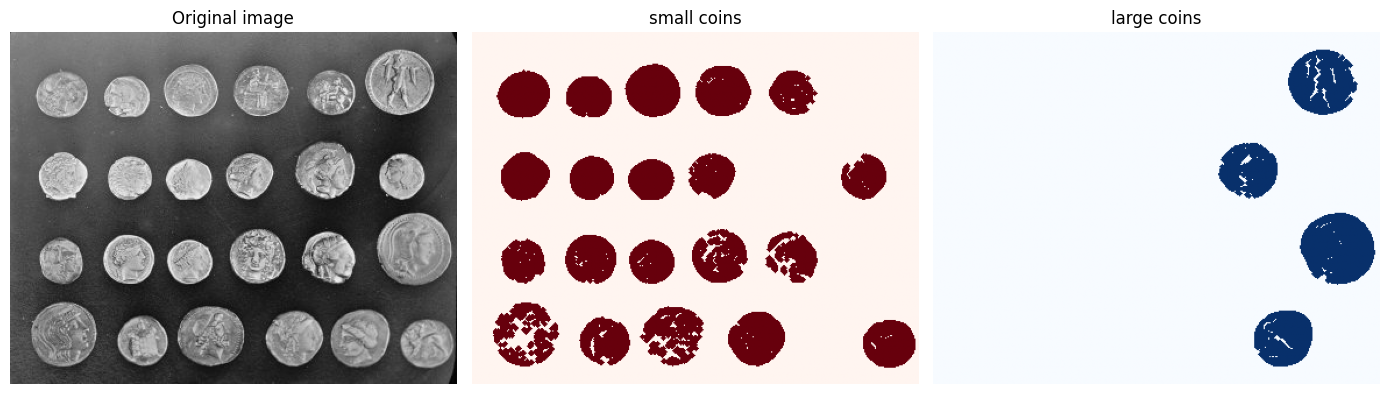

In [92]:
df_small_coins = df_features.loc[df_features['area']<= 1750]

labels_small = df_small_coins['label'].values
print('labels of small coins: {}'.format(labels_small))
labels_large = df_large_coins['label'].values
print('labels of large coins: {}'.format(labels_large))

mask_small_blobs = np.isin(label_image,labels_small)
mask_large_blobs = np.isin(label_image,labels_large)

# Get some figures:
fig, axes = plt.subplots(1,3,figsize=(14, 9))
ax = axes.ravel()
ax[0].imshow(coins,cmap=plt.cm.gray)
ax[0].set_title('Original image')
ax[1].imshow(mask_small_blobs,cmap=plt.cm.Reds)
ax[1].set_title('small coins') # set figure title
ax[2].imshow(mask_large_blobs,cmap=plt.cm.Blues)
ax[2].set_title('large coins')

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()
plt.tight_layout()
plt.show()

9. Describe the main steps required to perform segmentation of an RGB image using an unsupervised clustering algorithm (use other algorithms different than K-Means and compare the results)

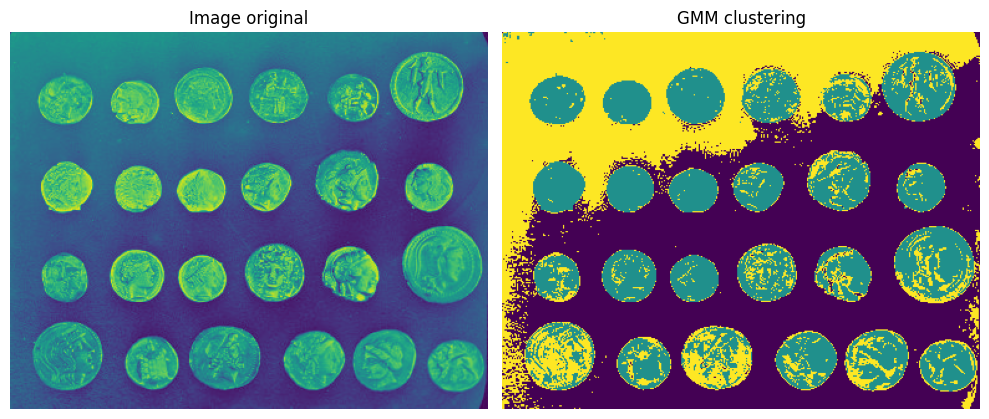

In [93]:
import skimage as sk # load skimage libraries
import numpy as np
from sklearn import mixture
import matplotlib.pyplot as plt
from matplotlib import gridspec

gmm = mixture.GaussianMixture(n_components=3).fit(v_I) # Fit a GMM model
v_gmm = gmm.fit_predict(v_I) # Predict GMM cluster labels for each pixel
I_gmm = np.reshape(v_gmm,(coins.shape[0],coins.shape[1])) # reshape back to original image size

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2)

ax0 = fig.add_subplot(gs[0,0])
ax0.imshow(coins)
ax0.set_title('Image original')
ax0.set_axis_off()

ax1 = fig.add_subplot(gs[0,1])
ax1.imshow(I_gmm)
ax1.set_title('GMM clustering')
ax1.set_axis_off()

plt.tight_layout()
plt.show()


#GMM clustering assumes that data points are generated from a mixture of several
# Gaussian distributions, each representing a distinct cluster.
# Unlike K-Means, which assigns each data point to a single cluster,
# GMM performs "soft" clustering by assigning a probability of belonging to each cluster.
#The algorithm iteratively estimates the parameters (mean, covariance, and mixing proportion)
#for each Gaussian component using the Expectation-Maximization (EM) algorithm.
#The E-step calculates the probability (responsibility) of each data point belonging to each cluster,
#while the M-step updates the cluster parameters based on these responsibilities.
# GMMs are more flexible than K-Means as they can model clusters of various shapes and sizes, not just spherical ones.

10. Extract the main texture features of this image

Texture features from coins image (mean across distances and angles):
contrast: 694.9934
dissimilarity: 13.0520
homogeneity: 0.1767
energy: 0.0165
correlation: 0.8762
ASM: 0.0003


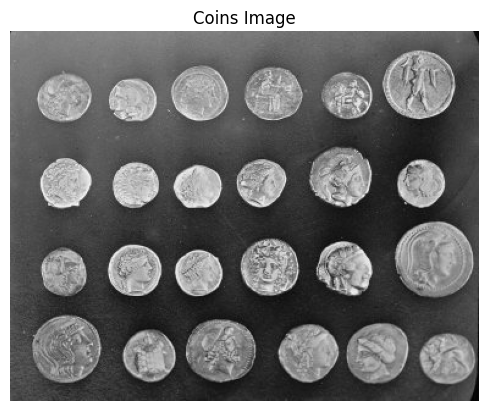

In [94]:
import matplotlib.pyplot as plt
from skimage import data
from skimage.feature import graycomatrix, graycoprops
import numpy as np

#we are computing the features using the graycomatrix and graycoprops
#graycomatrix() calculates the co-occurrence matrix for pixel pairs separated by given distances and angles.
#graycoprops() computes texture metrics from the GLCM.
#We compute metrics for multiple distances and angles and then average them to get a general texture summary.


# Load the coins image (already grayscale)
image = coins

# Parameters for GLCM
# Distances: pixel pair distance(s)
distances = [1, 2, 3]
# Angles: directions in radians (0, 45, 90, 135 degrees)
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

# Compute the Gray Level Co-occurrence Matrix (GLCM)
# levels=256 because grayscale is 8-bit, symmetric=True for symmetry, normed=True for normalized values
glcm = graycomatrix(image,
                    distances=distances,
                    angles=angles,
                    levels=256,
                    symmetric=True,
                    normed=True)

# Extract texture properties for each distance and angle
features = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
texture_features = {}

for feature in features:
    vals = graycoprops(glcm, prop=feature)
    texture_features[feature] = vals

# Print mean values across distances and angles for each feature
print("Texture features from coins image (mean across distances and angles):")
for feature in features:
    mean_val = texture_features[feature].mean()
    print(f"{feature}: {mean_val:.4f}")

# Optional: visualize the coins image
plt.imshow(image, cmap='gray')
plt.title("Coins Image")
plt.axis('off')
plt.show()


Personal discussion
Provide a thoughtful reflection on the Computer Vision course, including your perspective on the knowledge you have acquired and your opinion about the professor. (Thank you very much for your feedback!)

This course has helped me a lot in understanding the processing of images that is necessary for ML algorithms. The course has been fun and very informative.
Also the proffessor has been very good and has explained in theory and with practical examples to make the course more fun and effective.